In [1]:
import numpy as np, matplotlib.pyplot as plt, librosa as lr, librosa.display
from IPython.display import Audio

# 1. Load Audio

In [2]:
import os
path = os.path.join('..', '..', 'data', 'snd', 'beatles.wav')

y, sr = lr.load(path, sr=None)

display(Audio(y, rate=sr))

# 2. Chromagramm

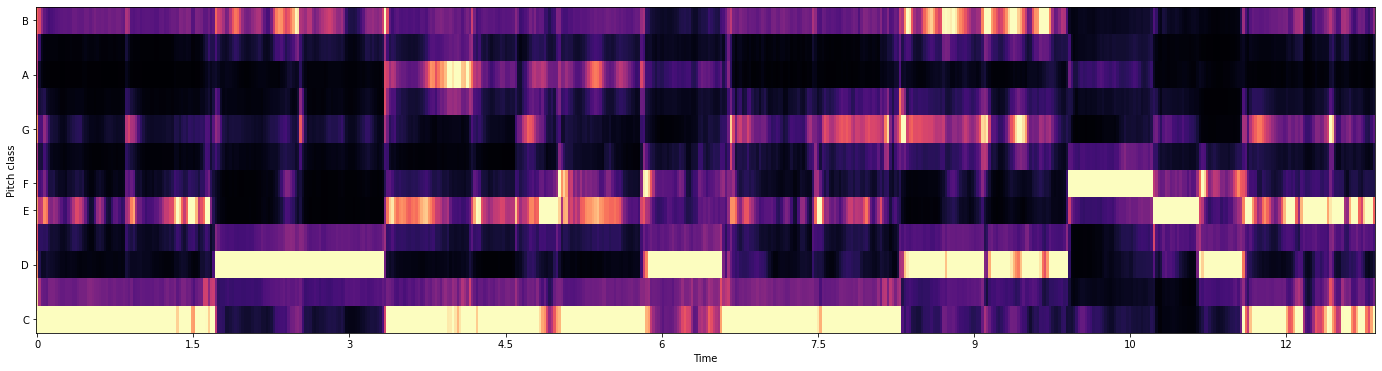

In [3]:
chroma = lr.feature.chroma_stft(y=y)

plt.figure(figsize=(24, 6))
lr.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.show()

# 3. Create Templates

`np.roll`

In [4]:
np.empty((3, 4))

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [5]:
a = np.arange(8)

print(np.roll(a, 0))
print(np.roll(a, 1))
print(np.roll(a, 2))
print(np.roll(a, 3))
# etc.

[0 1 2 3 4 5 6 7]
[7 0 1 2 3 4 5 6]
[6 7 0 1 2 3 4 5]
[5 6 7 0 1 2 3 4]


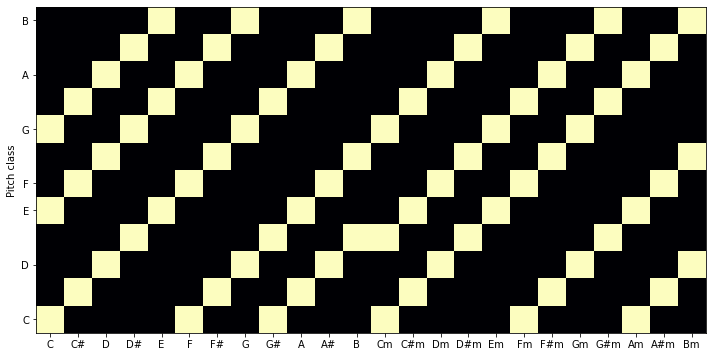

In [6]:
c_names = np.array(['C', 'C#', 'D', 'D#', 'E', 'F',
                    'F#', 'G', 'G#', 'A', 'A#', 'B',
                    'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm',
                    'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'])

cmaj_template = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
cmin_template = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

chord_templates = np.empty((24, 12))

for i in range(12):

    chord_templates[i] = np.roll(cmaj_template, i)
    chord_templates[i + 12] = np.roll(cmin_template, i)

plt.figure(figsize=(12, 6))
lr.display.specshow(chord_templates.T, y_axis='chroma')
plt.xticks(np.arange(24), c_names)
plt.show()

# 4. Matrix Multiplication

`np.matmul`

![|100](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Matrix_multiplication_diagram_2.svg/1920px-Matrix_multiplication_diagram_2.svg.png)

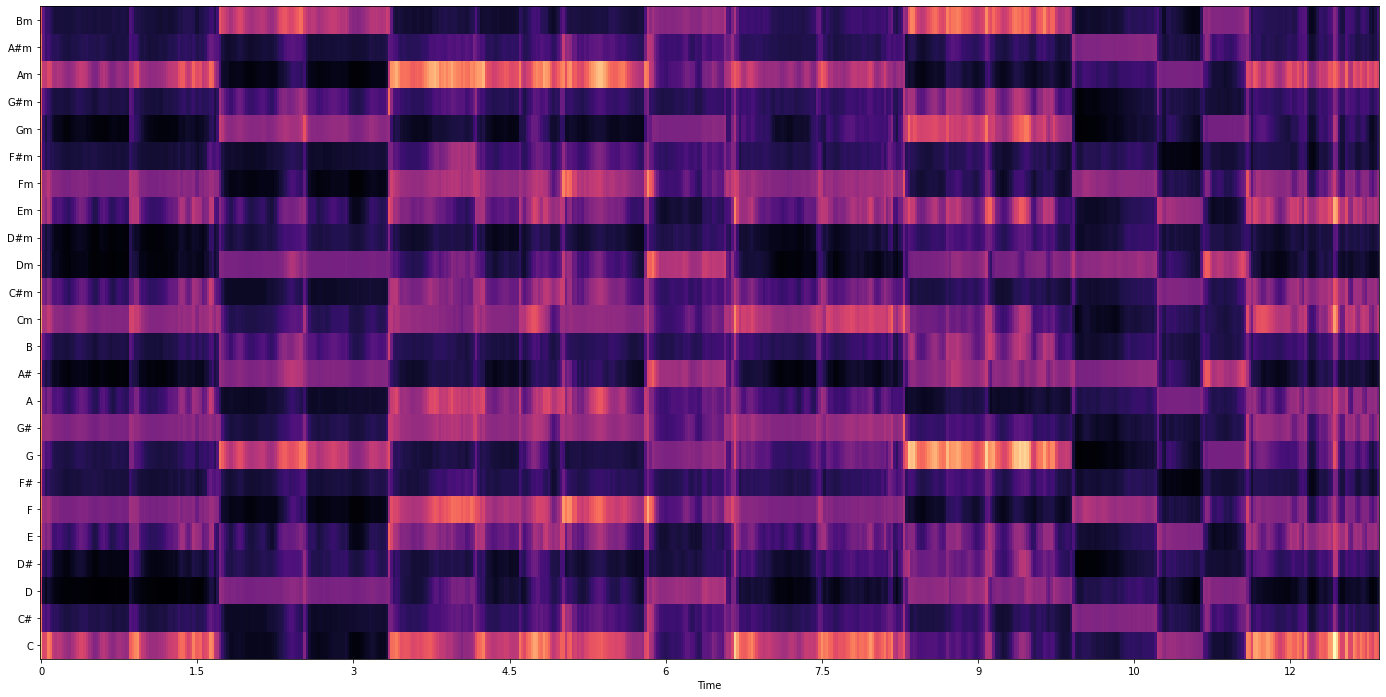

In [7]:
chord_sim = np.matmul(chord_templates, chroma)

plt.figure(figsize=(24, 12))
lr.display.specshow(chord_sim, x_axis='time')
plt.yticks(np.arange(24), c_names)
plt.show()

# 5. Find Max for each Window

`np.argmax`

In [8]:
a = np.random.rand(10)
print(a, '\n')

print(np.max(a))
print(np.argmax(a))

[0.29813788 0.29427244 0.4151111  0.83443975 0.46657062 0.82316332
 0.31496841 0.07152097 0.92851743 0.94616168] 

0.9461616812224733
9


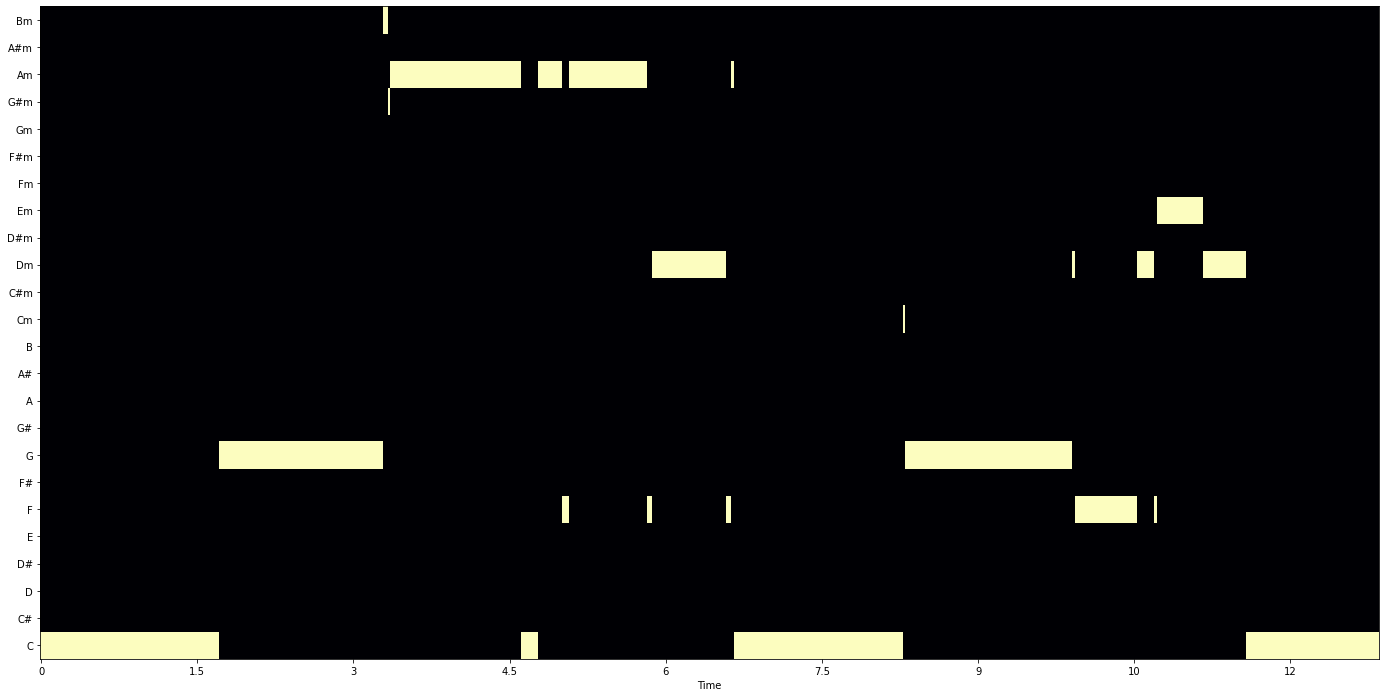

In [9]:
chord_seq = np.argmax(chord_sim, axis=0)

# chords = np.zeros_like(chord_sim)
chords = np.zeros(chord_sim.shape)

for i in range(chords.shape[1]):
    chords[chord_seq[i], i] = 1

# alternativ ohne loop:
# chords[chord_seq, np.arange(chords.shape[1])] = 1

plt.figure(figsize=(24, 12))
lr.display.specshow(chords, x_axis='time')
plt.yticks(np.arange(24), c_names)
plt.show()

# Sonification

In [10]:
def mtof(p):
    return 440 * ( 2 ** ((p - 69) / 12) )

In [11]:
length = y.size / sr
t = np.linspace(0, length, y.size)

# freqs
n_fft = 2048 // 4 # from lr defaults
fs = chord_templates[chord_seq].T
freqs = np.zeros((3, chord_seq.size))
for i in range(chord_seq.size):
    freqs[:, i] = np.argwhere(fs[:, i] == 1).T
freqs = freqs + 60
freqs = mtof(freqs)
freqs = np.repeat(freqs, n_fft, axis=1)
freqs = freqs[:, :y.size]

y_s = np.sum(np.sin(2 * np.pi * t[None, :] * freqs), axis=0)
display(Audio(y_s, rate=sr))